# Calculate Imputation Quality

In [1]:
import numpy as np
import pandas as pd
import os
import sys as sys
import socket
import matplotlib.pyplot as plt
import multiprocessing as mp
import itertools as it
import pandas as pd
import h5py
#from adjustText import adjust_text

import warnings
warnings.filterwarnings("ignore") # Great Style
socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("No compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

compute-e-16-229.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 28


### Load Imputed H5 File

In [2]:
version="54.1"
folder_in =  f"/n/groups/reich/hringbauer/git/hapBLOCK/data/hdf5/1240k_v{version}/ch" # for hdf5
ch = 20

path_meta = f"/n/groups/reich/hringbauer/Data/v{version}.anno.csv"
df_meta = pd.read_csv(path_meta, sep=',')
print(f"Loaded Meta File with {len(df_meta)} IIDs")
df_meta["study"]=df_meta["study"].fillna("missing")

idx = df_meta["data_type"]=="1240k"
idx1  = df_meta["data_type"]=="Shotgun"
print(f"#1240 Individuals: {np.sum(idx)}")
print(f"#WGS Individuals: {np.sum(idx1)}")

Loaded Meta File with 33967 IIDs
#1240 Individuals: 434
#WGS Individuals: 5969


In [ ]:
df_meta["data_type"].value_counts()

In [3]:
%%time
# 7s for 1000 indivdiuals.
# 2min52s for 33967 indivdiuals
with h5py.File(f"{folder_in}{ch}.h5", "r") as f: # Load for Sanity Check. See below!
    print(list(f))
    print(list(f["calldata"]))
    gp = f["calldata/GP"][:,:,:]
    ad = f["calldata/AD"][:,:,:2]
    samples = f["samples"][:]
print(f"Loaded {len(samples)} Names. GP shape:")
print(np.shape(gp))

['calldata', 'samples', 'variants']
['AD', 'DS', 'GP', 'GT', 'HS', 'PL']
Loaded 27684 Names. GP shape:
(28940, 27684, 3)
CPU times: user 1min 1s, sys: 8.33 s, total: 1min 9s
Wall time: 1min 10s


In [4]:
def get_sum_gp_good(gp, cutoff=0.99):
    """Get cutoff of samples with maxGP above threshold."""
    gp_max = np.max(gp, axis=2) 
    gp_frac = np.mean(gp_max >= cutoff, axis=0)
    return gp_frac

def get_cov(ad):
    """Return coverage of allele depth >0"""
    ad_max = np.max(ad, axis=2)
    cov = np.sum(ad_max>0, axis=0)
    return cov

In [5]:
%%time

x = [0,10000,20000,30000]

gps = []
covs = []

for i in range(len(x)-1):
    print(i)
    gp_frac = get_sum_gp_good(gp[:,x[i]:x[i+1],:])
    cov = get_cov(ad[:,x[i]:x[i+1],:])
    
    gps.append(gp_frac)
    covs.append(cov)
cov = np.concatenate(covs)
gp_frac = np.concatenate(gps)

0
1
2
CPU times: user 32.4 s, sys: 5.13 s, total: 37.5 s
Wall time: 37.5 s


### Merge with Meta File Info

In [6]:
df1 = pd.DataFrame({"iid":samples[:].astype("str"), "cov":cov, "gp_frac":gp_frac})
dft = pd.merge(df_meta, df1, on="iid")
print(f"Intersection: {len(dft)} of {len(df_meta)} and {len(df1)}")

df_wgs = dft[dft["data_type"]=="Shotgun"]
df_twist = dft[dft["data_type"]=="Twist1.4M"]
df_1240k =  dft[dft["data_type"]=="1240K"]

Intersection: 27684 of 33967 and 27684


In [12]:
len(df_1240k)

19046

In [ ]:
dft["data_type"].value_counts()

In [7]:
exclude_studies = ["MargaryanWillerslevNature2020", "CassidyNature2020", "SeguinOrlandoCurrBio2021", 
                   "Unpublished (Pere Gelabert LBK)", "MorenoMayarScience2018", "ClementeCell2021",
                   "KilincSciAdv2021", "McCollScience2018", "SikoraNature2019", "CoutinhoJakobssonAJPA2020", 
                   "Unpublished (Alissa Dusan Mesolithic-Neolithic)"]
exclude_iids = ["Goyet_final", "Denisova11", "Mezmaiskaya2_final", "Mezmaiskaya1", "Les_Cottes_final"]

df_wgs1 = df_wgs[~df_wgs["study"].isin(exclude_studies)]
df_wgs1 = df_wgs1[~df_wgs1["Master ID"].isin(exclude_iids)]

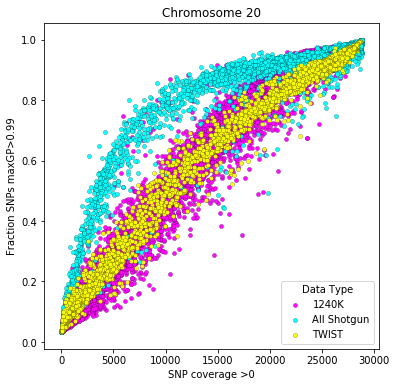

In [13]:
plt.figure(figsize=(6,6))
ax = plt.gca()

s=18
lw=0.2
ax.scatter(df_1240k["cov"], df_1240k["gp_frac"], c="magenta", ec="k", alpha=0.95, label="1240K",s=s, lw=lw)

ax.scatter(df_wgs1["cov"], df_wgs1["gp_frac"], c="aqua", ec="k", alpha=0.95, label="All Shotgun", s=s, lw=lw)
ax.scatter(df_twist["cov"], df_twist["gp_frac"], c="yellow", ec="k", alpha=0.95, label="TWIST", s=s, lw=lw)
#df_w = df_wgs[df_wgs["study"]=="AntonioGaoMootsScience2019"]
#ax.scatter(df_w["cov"], df_w["gp_frac"], c="green", ec="k", alpha=0.8, label="Antonio et al 2019")

#df_w = df_wgs[df_wgs["study"]=="MargaryanWillerslevNature2020"]
#ax.scatter(df_w["cov"], df_w["gp_frac"], c="red", ec="k", alpha=0.8, label="Margaryan et al 2020")

#df_w = df_wgs[df_wgs["study"]==]
#ax.scatter(df_w["cov"], df_w["gp_frac"], c="yellow", ec="k", alpha=0.8, label="Cassidy et al 2020")

#df_w = df_wgs[df_wgs["study"]=="SeguinOrlandoCurrBio2021"]
#ax.scatter(df_w["cov"], df_w["gp_frac"], c="orange", ec="k", alpha=0.8, label="Orlando et al 2021")

ax.set_xlabel("SNP coverage >0")
ax.set_ylabel("Fraction SNPs maxGP>0.99")
ax.set_title("Chromosome 20")
ax.legend(loc="lower right", title="Data Type")

plt.savefig("./figs/dumpster/imputation_QC_ch20.pdf", bbox_inches ='tight', pad_inches = 0, dpi=400)
plt.show()

# Plot coverage per SNP

In [12]:
print("test")

test


In [15]:
df_1240k["avg_cov_snp"]

112      9.961275
284            ..
337            ..
344            ..
368            ..
           ...   
27676           0
27678    0.001544
27679    0.004824
27681           0
27683           0
Name: avg_cov_snp, Length: 19046, dtype: object

In [14]:
plt.figure(figsize=(6,6))
ax = plt.gca()

s=18
lw=0.2
ax.scatter(df_1240k["avg_cov_snp"], df_1240k["gp_frac"], c="magenta", ec="k", alpha=0.95, label="1240K",s=s, lw=lw)

ax.scatter(df_wgs1["avg_cov_snp"], df_wgs1["gp_frac"], c="aqua", ec="k", alpha=0.95, label="All Shotgun", s=s, lw=lw)
ax.scatter(df_twist["avg_cov_snp"], df_twist["gp_frac"], c="yellow", ec="k", alpha=0.95, label="TWIST", s=s, lw=lw)

ax.set_xlabel("SNP coverage >0")
ax.set_ylabel("Fraction SNPs maxGP>0.99")
ax.set_title("Chromosome 20")
ax.legend(loc="lower right", title="Data Type")

plt.savefig("./figs/dumpster/imputation_QC_ch20_avg.cov.pdf", bbox_inches ='tight', pad_inches = 0, dpi=400)
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fe511963c20> (for post_execute):


KeyboardInterrupt: 

# Filter bad shotgun data

In [37]:
df_wgs1[(df_wgs1["cov"]>55000) & (df_wgs1["gp_frac"]<0.8)]

,iid,Master ID,loc,lat,lon,age,age_range,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,family,sex,contact,data_type,cov,gp_frac
3031,I18436.SG,I18436,Moca,19.395278,-70.524444,199.0,"1653-1950 calCE (205±15 BP, PSUAMS-9163)",Dominican Republic,Unpublished,Dominican_Moca_Colonial_Mestizo.SG,0.822524,987029,1.985424,True,n/a (no relatives detected),M,"Pinhasi, Ron",Shotgun,68489,0.793096
4596,I14762.SG,I14762,"Oylum Höyük (Southeast, Kilis)",36.690000,37.170000,3583.0,"1736-1541 calBCE (3355±25 BP, PSUAMS-6841)",Turkey,Unpublished (shotgun),Turkey_MBA.SG,0.735982,883178,1.483719,True,n/a (no relatives detected),M,"Alpaslan, Songül; Engin, Atilla; Açıkkol-Yıldı...",Shotgun,61854,0.792721
4728,I20032.SG,I20032,Al Wafi,NaN,NaN,404.0,"1461-1630 calCE (360±15 BP, PSUAMS-8412)",Oman,Unpublished,Oman_LatEMedieval.SG,0.732059,878471,1.442209,True,n/a (no relatives detected),M,"Altena, Eveline",Shotgun,61439,0.782352
5212,I18435.SG,I18435,Moca,19.395278,-70.524444,145.0,"1660-1950 calCE (195±15 BP, PSUAMS-9162)",Dominican Republic,Unpublished,Dominican_Moca_Colonial_Mestizo.SG,0.717212,860654,1.361419,True,"Dominican Republic, Moca Family A (2 members) ...",M,"Pinhasi, Ron",Shotgun,60433,0.780193
6084,I14784.SG,I14784,"Oylum Höyük (Southeast, Kilis)",36.690000,37.170000,3695.0,"1876-1632 calBCE (3435±25 BP, PSUAMS-6834)",Turkey,Unpublished (shotgun),Turkey_MBA.SG,0.699325,839190,1.316387,True,"Turkey, Southeast, Kilis, Oylum H�y�k Family A...",M,"Alpaslan, Songül; Engin, Atilla; Açıkkol-Yıldı...",Shotgun,59102,0.771362
6208,I9133_noUDG.SG,UCT386,Faraoskop Rock Shelter,-31.980439,18.517695,1910.0,"88 calBCE - 202 calCE (2000±50 BP, Pta-5283)",South Africa,SkoglundCell2017,South_Africa_1900BP.SG,0.697356,836827,2.328,True,n/a (no relatives detected),M,"Krause, Johannes",Shotgun,70287,0.766759
8138,I20192.SG,I20192,"Samara Oblast, Volga River Valley, Southern St...",53.085611,49.465911,7098.0,"5297-5050 calBCE (6210±30 BP, PSUAMS-9700)",Russia,Unpublished,Russia_Ekaterinovka_Eneolithic.SG,0.664840,797808,1.190838,True,"Samara Oblast, Volga River Valley, Southern St...",F,"Khokhlov, Alexander",Shotgun,56710,0.768117
8386,I18463.SG,I18463,"Mar Bravo, Punta Carnero, 362A",-2.250245,-80.919929,884.0,600-1532 CE,Ecuador,Unpublished,Ecuador_Ceramic_MantenoHuancavilca.SG,0.659992,791991,1.186627,True,"Ecuador, Mar Bravo Family C (2 members) (I1846...",M,"Pinhasi, Ron",Shotgun,56676,0.792540
9046,kol6_noUDG.SG,kol006,Kolín,50.028889,15.201157,6775.0,"4929-4726 calBCE (5950±25 BP, UGAMS-9615)",Czech Republic,SanchezQuintoPNAS2019,Czech_MN.SG,0.647920,777504,1.437478,True,n/a (no relatives detected),F,SanchezQuintoPNAS2019,Shotgun,59052,0.772254
14422,RISE1281_noUDG.SG,RISE1280,"Eastern Jutland, Djursland, Gjerrild Cist",56.500000,10.820000,4226.0,2567-1984 calBCE [union of two dates: 2567-230...,Denmark,EgfjordAllentoftPLOS2021,Denmark_Djursland_SingleGraveCulture.SG,0.466633,559959,0.956609,True,RISE1281.SG-RISE1280.SG are duplicates,M,"Egfjord, Anne Friis-Holm; Allentoft, Morten",Shotgun,55127,0.700175


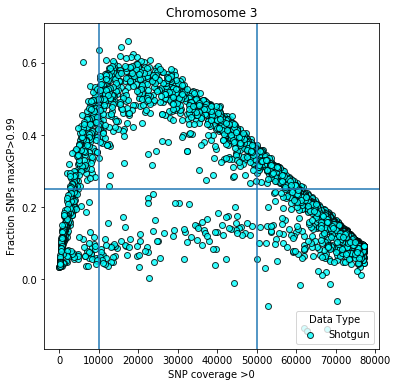

In [20]:
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.scatter(df_wgs1["cov"], df_wgs1["gp_frac"]-df_wgs1["cov"]/85000, c="aqua", ec="k", alpha=0.8, label="Shotgun")
ax.set_xlabel("SNP coverage >0")
ax.set_ylabel("Fraction SNPs maxGP>0.99")
ax.set_title("Chromosome 3")
ax.legend(loc="lower right", title="Data Type")
ax.axhline(0.25)
ax.axvline(50000)
ax.axvline(10000)
plt.show()

In [21]:
cov_quality = df_wgs1["gp_frac"]-df_wgs1["cov"]/85000
idx = cov_quality<0.25
idx1 = (df_wgs1["cov"]>10000) & (df_wgs1["cov"]<50000)
df_f = df_wgs1[idx & idx1]

In [22]:
df_f["study"].value_counts()

Unpublished (Alissa Dusan Mesolithic-Neolithic)                                            14
KilincSciAdv2021                                                                           14
McCollScience2018                                                                          11
SikoraNature2019                                                                           10
CoutinhoJakobssonAJPA2020                                                                  10
Unpublished (shotgun)                                                                       8
Unpublished                                                                                 6
BraceDiekmannNatureEcologyEvolution2019                                                     6
SanchezQuintoPNAS2019                                                                       6
WangCell2021                                                                                3
Unpublished (Arie Finkelstein Israel IA)                    

In [24]:
df_wgs[df_wgs["study"]=="Unpublished (Alissa Dusan Mesolithic-Neolithic)"]

,iid,Master ID,loc,lat,lon,age,age_range,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,family,sex,contact,data_type,cov,gp_frac
3189,I20500.SG,I20500,Smilcic,44.128390,15.502731,7050.0,5250-4950 BCE,Croatia,Unpublished (Alissa Dusan Mesolithic-Neolithic),Croatia_N_Cardial.SG,0.814214,977057,2.010542,True,n/a (no relatives detected),M,"Pinhasi, Ron",Shotgun,68054,0.888577
3393,I17119.SG,I17119,"Iron Gates, Ostrovul Banului",44.506944,22.553056,587.0,"1320-1419 calCE (570±20 BP, PSUAMS-8831)",Romania,Unpublished (Alissa Dusan Mesolithic-Neolithic),Romania_IronGates_Medieval.SG,0.802031,962437,1.819061,True,n/a (no relatives detected),M,"Bonsall, Clive",Shotgun,66901,0.868860
8797,I16295.SG,I16295,Brăiliţa,45.301785,27.966771,7866.0,"5994-5805 calBCE (7030±35 BP, PSUAMS-11077)",Romania,Unpublished (Alissa Dusan Mesolithic-Neolithic),Romania_Brailita_Mesolithic.SG,0.652854,783425,1.175134,True,Brăiliţa Family E (8 members) (son-father: I23...,F,"Pinhasi, Ron",Shotgun,55654,0.782701
12826,I16235.SG,I16235,Brăiliţa,45.301785,27.966771,7908.0,"6028-5851 calBCE (7085±35 BP, PSUAMS-11045)",Romania,Unpublished (Alissa Dusan Mesolithic-Neolithic),Romania_Brailita_Mesolithic_father.or.son.I104...,0.539465,647358,0.834604,True,Brăiliţa Family J (3 members) (brothers: I1047...,M,"Pinhasi, Ron",Shotgun,46044,0.685642
13016,I16290.SG,I16290,Brăiliţa,45.301785,27.966771,7917.0,"6059-5892 calBCE (7095±35 BP, PSUAMS-11054)",Romania,Unpublished (Alissa Dusan Mesolithic-Neolithic),Romania_Brailita_Mesolithic.SG,0.531200,637440,0.81289,True,Brăiliţa Family G (4 members) (1d: I16232-I157...,M,"Pinhasi, Ron",Shotgun,45560,0.679035
13635,I16299.SG,I16299,Brăiliţa,45.301785,27.966771,7077.0,5217-5037 calBCE (6186±28 BP) [R_combine: (617...,Romania,Unpublished (Alissa Dusan Mesolithic-Neolithic),Romania_Brailita_Mesolithic.SG,0.503327,603993,0.749081,True,n/a (no relatives detected),M,"Pinhasi, Ron",Shotgun,43393,0.649428
15582,I17799.SG,I17799,Vlasac,44.550000,22.020000,9750.0,9800-5800 BCE,Serbia,Unpublished (Alissa Dusan Mesolithic-Neolithic),Serbia_IronGates_Mesolithic.SG,0.401412,481694,0.543322,True,n/a (no relatives detected),F,"Borić, Dušan",Shotgun,36023,0.583502
15749,I17827.SG,I17827,"Iron Gates, Icoana",44.674158,22.318439,8900.0,7500-6400 BCE,Romania,Unpublished (Alissa Dusan Mesolithic-Neolithic),Romania_IronGates_Mesolithic.SG,0.390763,468915,0.51931,True,n/a (no relatives detected),F,"Borić, Dušan",Shotgun,34284,0.554128
16314,I16297.SG,I16297,Brăiliţa,45.301785,27.966771,7550.0,6250-4950 BCE,Romania,Unpublished (Alissa Dusan Mesolithic-Neolithic),Romania_Brailita_Mesolithic.SG,0.356763,428116,0.466917,True,n/a (no relatives detected),M,"Pinhasi, Ron",Shotgun,31807,0.504816
16344,I17825.SG,I17825,Padina,44.610000,22.000000,10580.0,"8814-8354 calBCE (9364±67 BP, OxA-16939)",Serbia,Unpublished (Alissa Dusan Mesolithic-Neolithic),Serbia_IronGates_Mesolithic.SG,0.354857,425828,0.456957,True,n/a (no relatives detected),F,"Borić, Dušan",Shotgun,31627,0.512393


# Area 51

In [50]:
df_meta["Master ID"].value_counts()

I1685     8
I4012     8
I2963     8
I10872    7
I1072     6
         ..
I19644    1
I17589    1
FNO007    1
I11991    1
I17352    1
Name: Master ID, Length: 29307, dtype: int64

In [ ]:
dft

In [ ]:
df.to_csv(f"./notebook/vignette/data/afs/v51.1_1240k_AF_ch{ch}.tsv", sep="\t", index=False)